In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize':(25,10)})

**Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.**

Есть ли в данных пропущенные значения?

In [3]:
df = pd.read_csv('london.csv')

In [4]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [5]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [7]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [8]:
df.shape

(17414, 10)

In [9]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

**Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:**

- по оси x – дата (timestamp)
- по оси y – число поездок (cnt)

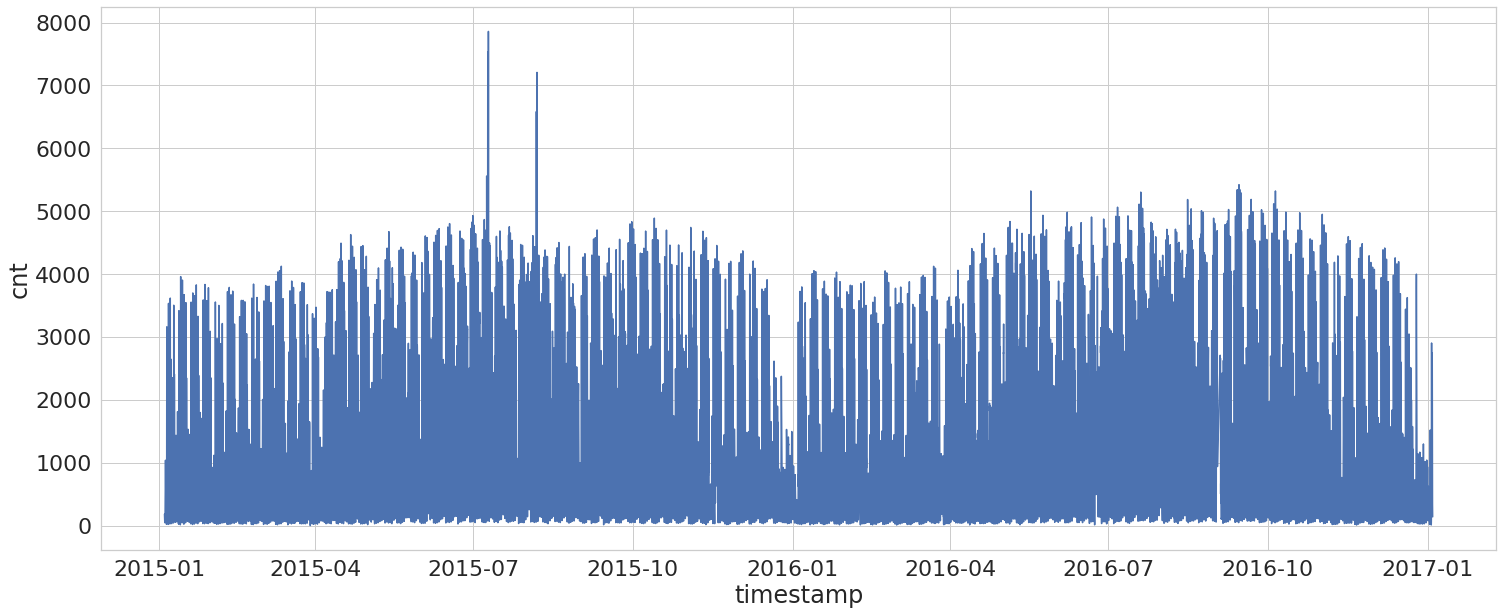

In [10]:
sns.lineplot(data=df, x='timestamp', y='cnt')

In [11]:
# Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

**Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample.
Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?**

In [12]:
df_date_to_day = df.sort_values('timestamp')

In [13]:
df_date_to_day = df_date_to_day.set_index('timestamp')

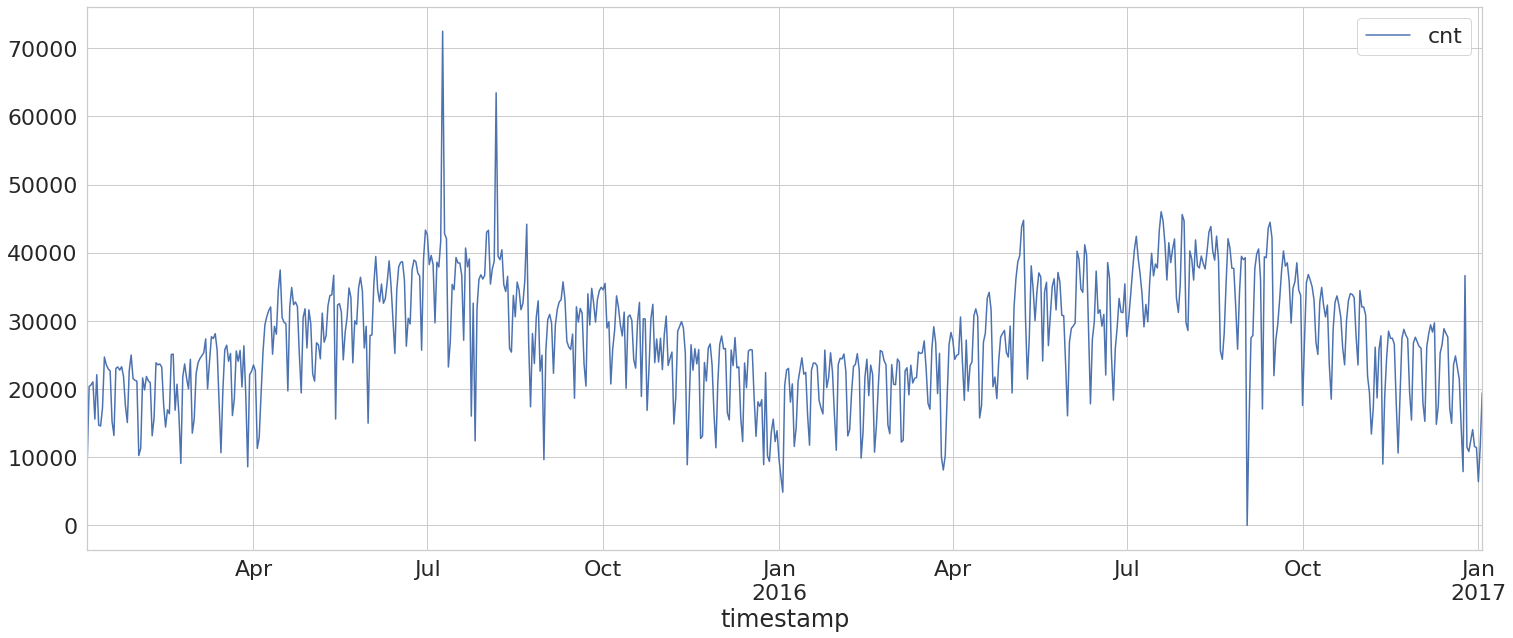

In [14]:
df_date_to_day = df_date_to_day.resample(rule='D').agg({'cnt':'sum'}) #  .resample() - позволяет преобразовать данные и 
df_date_to_day.plot()                                               # применить к ним другой метод (sum(), size() и пр.). 

In [15]:
# Встречаются как очень резкие скачки числа аренд, так и падения
# Зимой число аренд меньше, чем летом
# Максимальное число аренд за день составляет более 70 000

**Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день.**

**Для этого разделим дальнейшие действия на несколько этапов:**

- сначала посчитаем скользящее среднее, чтобы сгладить ряд
- далее – разницу между наблюдаемыми и сглаженными значениями
- определим верхние и нижние границы 99% доверительного интервала 
- найдем причины аномалий!

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [16]:
df_date_to_day_ma = df_date_to_day.rolling(window=3).mean().reset_index('timestamp')

In [17]:
round(df_date_to_day_ma.query('timestamp == "2015-07-09"'))

,timestamp,cnt
186,2015-07-09,50705.0


**Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения.**


В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [18]:
df_date_to_day = df_date_to_day.reset_index('timestamp')

In [19]:
df_std = df_date_to_day.cnt - df_date_to_day_ma.cnt

In [20]:
round(np.std(df_std), 2)

4558.59

**Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:**

- upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
- lower_bound – нижняя граница; вычитаем 2.576∗std
- Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

In [37]:
df_date_to_day['upper_bound'] = df_date_to_day_ma.cnt + 2.576 * np.std(df_std)

In [38]:
df_date_to_day['lower_bound'] = df_date_to_day_ma.cnt - 2.576 * np.std(df_std)

In [39]:
df_date_to_day.tail(1)

,timestamp,cnt,upper_bound,lower_bound
730,2017-01-03,19436,24302.919188,817.080812


In [41]:
round(24302.919188, 2)

24302.92

**И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.**

В какой день значение числа аренд оказалось наибольшим?

In [61]:
df_date_to_day.query('cnt > upper_bound').sort_values('cnt', ascending=False)

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.919188,38962.080812
214,2015-08-06,63468,58370.252521,34884.414146
721,2016-12-25,36653,31393.585854,7907.747479
609,2016-09-04,27512,26001.919188,2516.080812


In [ ]:
# 2015-07-09 в Лондоне была забастовка работников метро, которая привела к транспортному хаосу.
# Люди в этот день массово арендовали велосипеды

**Проделайте аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?**

In [62]:
df_date_to_day.query('cnt < lower_bound').sort_values('cnt', ascending=False)

,timestamp,cnt,upper_bound,lower_bound
189,2015-07-12,23240,47779.585854,24293.747479
621,2016-09-16,21967,47936.252521,24450.414146
232,2015-08-24,17400,41272.252521,17786.414146
615,2016-09-10,17080,43004.919188,19519.080812
201,2015-07-24,16034,42756.585854,19270.747479
130,2015-05-14,15609,40452.252521,16966.414146
678,2016-11-12,8990,32620.919188,9135.080812
314,2015-11-14,8898,32780.252521,9294.414146
607,2016-09-02,0,37829.252521,14343.414146


In [64]:
df_date_to_day.query('cnt == 0')

,timestamp,cnt,upper_bound,lower_bound
607,2016-09-02,0,37829.252521,14343.414146


In [66]:
# Только один день из всей таблиицы показывает ноль аренд по всему Лондону, 
# либо вся сеть аренд была закрыта (что в задании не подразумевается), либо, скорее всего это ошибка при записывании данных.